# 1.Import Libraries and Data

In [1]:
# Basic packages
import numpy as np
import pandas as pd
import datetime
from itertools import product
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


### In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

### We are asking you to predict total sales for every product and store in the next month. 

* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category





# 2. Data Cleaning

* Check outliers
* Merge Files
* Convert some variable's type
* Check abrnomal values
* Check null values
* Check the difference between train and test set

## 2.1 Handling data in train

### 2.1.1 For 'item_cnt_day'

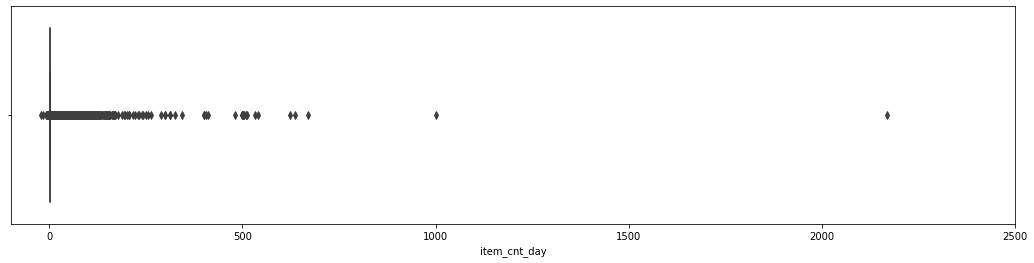

In [6]:
plt.figure(figsize=(18,4))
plt.xlim(-100,2500)
sns.boxplot(train['item_cnt_day'])

Delete some observations due to their higher item_cnt_day

In [7]:
train.loc[train['item_cnt_day']>900]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


Some item's per-day sale is negative. This item might be lost,stolen or due to some other reasons happened that day. Therefore, these values cannot be regarded as sales.

In [8]:
train.loc[train['item_cnt_day']<-5]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
59156,18.01.2013,0,12,1590,2599.000000,-6.0
940092,19.10.2013,9,42,3732,2599.000000,-6.0
1057907,02.11.2013,10,12,8023,15.000000,-22.0
1835454,10.07.2014,18,14,20949,5.000000,-16.0
2048519,10.10.2014,21,12,9242,1433.333333,-9.0


In [9]:
indexvalue = train.loc[(train['item_cnt_day']<-5)|(train['item_cnt_day']>900)].index.values
train = train.drop(train.index[indexvalue])

### 2.1.2 For 'item_price'

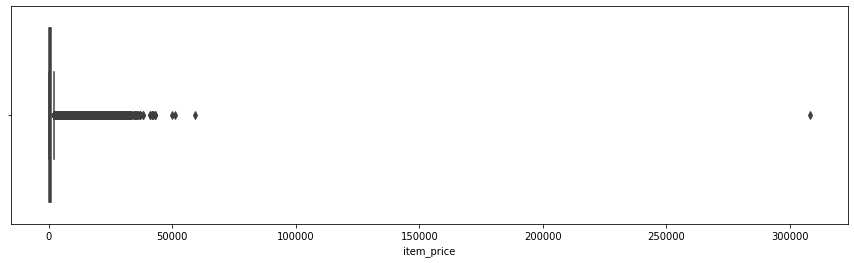

In [10]:
plt.figure(figsize=(15,4))
sns.boxplot(train['item_price'])

Only one item's price is too high in this dataset. This is abnormal.

In [11]:
train.loc[train['item_price']>250000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [12]:
train = train.drop(train.index[1163158])

Also one item's price is negative. So we can replace this price using this item's mean or median.

In [13]:
train.loc[train['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [14]:
val_mean = train[train['item_id']==2973].item_price.mean()

In [15]:
train.loc[train['item_price']<0,'item_price'] = val_mean

In [16]:
s3 = train.pivot_table(index=['shop_id'],values=['item_cnt_day'], 
                  columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()

As we can see from the table below, for some shop, the 'item_cnt_day' is 0 in some date_block_num:
* shop_id: 0, 1, 8, 9,13, 17, 23, 30, 32, 33, 34, 40, 43, 44, 51, 54 <br>

Then we can assume that these shop might be closed, whether it is temporarily or permanently we are not sure. Therefore we need to compare with the test set to decide wheter we need to delete these shop's information or keep them.

In [17]:
s3.style.background_gradient(cmap='Blues')

In [18]:
list(sorted(set(train.shop_id.unique()) - set(test.shop_id.unique())))

[0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]

Besides, there are some shops in train but not in test set.
* shop_id in train but not in test : `0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54`
* shop we assume it is closed: `0, 1, 8, 9, 11, 13, 17, 23, 30, 32, 33, 34, 40, 43, 44, 51, 54`

In [19]:
train[(train['shop_id']==0)|(train['shop_id']==1)|(train['shop_id']==8)|(train['shop_id']==9)|(train['shop_id']==11)|(train['shop_id']==13)|(train['shop_id']==17)|(train['shop_id']==23)|(train['shop_id']==30)|
     (train['shop_id']==32)|(train['shop_id']==33)|(train['shop_id']==34)|(train['shop_id']==40)|(train['shop_id']==43)|(train['shop_id']==44)|(train['shop_id']==51)|(train['shop_id']==54)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2466,15.01.2013,0,23,21567,379.0,1.0
2467,06.01.2013,0,23,21570,199.0,1.0
2468,05.01.2013,0,23,21771,449.5,1.0
2469,10.01.2013,0,23,21771,899.0,1.0
2470,23.01.2013,0,23,21619,499.0,1.0
...,...,...,...,...,...,...
2919696,02.10.2015,33,9,21950,1699.0,6.0
2919697,01.10.2015,33,9,21951,1699.0,2.0
2919698,04.10.2015,33,9,21951,1699.0,4.0
2919699,01.10.2015,33,9,21954,1599.0,3.0


In [20]:
inds = train[(train['shop_id']==0)|(train['shop_id']==1)|(train['shop_id']==8)|(train['shop_id']==9)|(train['shop_id']==11)|(train['shop_id']==13)|(train['shop_id']==17)|(train['shop_id']==23)|(train['shop_id']==30)|
     (train['shop_id']==32)|(train['shop_id']==33)|(train['shop_id']==34)|(train['shop_id']==40)|(train['shop_id']==43)|(train['shop_id']==44)|(train['shop_id']==51)|(train['shop_id']==54)].index

In [21]:
train = train.drop(inds)

### 2.1.3 Obtain the information about `item's` status

In [22]:
print(len(list(sorted(set(test.item_id.unique()) - set(train.item_id.unique())))))
print(len(list(sorted(set(train.item_id.unique()) - set(test.item_id.unique())))))

372
16393


There are `372` items in test but not in train, and `16,393` items in train but not in test. It might be difficult to forecast sales of the items in test but not in train.

## 2.2 Handling data in shops

In [21]:
shops.head(5)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


Add city column from "shop_name" and encode this column.

In [22]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split(" ")[0])

In [23]:
shops['city'] = shops['city'].apply(lambda x: x.lower())

In [24]:
from sklearn.preprocessing import LabelEncoder

In [25]:
encoder = LabelEncoder()

In [26]:
shops['city_code'] = encoder.fit_transform(shops['city'])

In [27]:
shops2 = shops[['shop_id','city_code']]

## 2.3 Handling data in item_category

In [28]:
item_cats.head(5)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [29]:
item_cats['first_split'] = item_cats.item_category_name.apply(lambda x: x.split(" - "))

In [30]:
item_cats['type'] = item_cats['first_split'].apply(lambda x: x[0])

In [31]:
item_cats['product'] = item_cats['first_split'].apply(lambda x: x[1] if len(x) > 1 else x[0])

In [32]:
item_cats['type_code'] = encoder.fit_transform(item_cats['type'])

In [33]:
item_cats['product_code'] = encoder.fit_transform(item_cats['product'])

In [34]:
item_cats2 = item_cats[['item_category_id','type_code','product_code']]

## 2.4 Merge all files for EDA

In [35]:
df1 = train.merge(shops,how='left',on='shop_id')
df1 = df1.merge(items,how='left',on='item_id')
df1 = df1.merge(item_cats,how='left',on='item_category_id')

In [36]:
df1.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,city,city_code,item_name,item_category_id,item_category_name,first_split,type,product,type_code,product_code
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ярославль,31,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"[Кино, Blu-Ray]",Кино,Blu-Ray,11,1
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",москва,14,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"[Музыка, Винил]",Музыка,Винил,13,29
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",москва,14,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"[Музыка, Винил]",Музыка,Винил,13,29
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",москва,14,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"[Музыка, Винил]",Музыка,Винил,13,29
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",москва,14,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"[Музыка, CD фирменного производства]",Музыка,CD фирменного производства,13,5


Convert some variable's type

In [37]:
df1['date'] = pd.to_datetime(df1['date'],errors='coerce')

In [38]:
df1 = df1.sort_values('date')

Check each column's value to see if it is appropriate.

In [39]:
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
date_block_num,2524339.0,15.052953,9.492669,0.00,7.0,14.0,23.0,33.0
shop_id,2524339.0,31.802162,16.016699,2.00,21.0,29.0,46.0,59.0
item_id,2524339.0,10104.924720,6320.004574,1.00,4374.0,8961.0,15539.5,22169.0
item_price,2524339.0,911.366917,1761.606861,0.07,249.0,399.0,999.0,307980.0
item_cnt_day,2524339.0,1.242762,2.282685,-5.00,1.0,1.0,1.0,669.0
city_code,2524339.0,16.563615,7.550906,1.00,14.0,14.0,22.0,31.0
item_category_id,2524339.0,39.757928,17.159788,0.00,28.0,40.0,55.0,83.0
type_code,2524339.0,9.808892,3.516781,0.00,8.0,11.0,13.0,19.0
product_code,2524339.0,22.999661,20.997598,0.00,6.0,13.0,43.0,66.0


Also, we need to check that if there exists null value.

In [40]:
df1.isna().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
shop_name             0
city                  0
city_code             0
item_name             0
item_category_id      0
item_category_name    0
first_split           0
type                  0
product               0
type_code             0
product_code          0
dtype: int64

Apparently, there is no null values here.

# 3. EDA

Extract year, month, day and weekday based on the 'date' column.

In [41]:
df1['month-year'] = df1.date.dt.to_period('m')
df1['Year'] = df1.date.dt.year
df1['Month'] = df1.date.dt.month
df1['Day'] = df1.date.dt.day
df1['Weekday'] = df1['date'].dt.day_name()

Calculate the revenue using 'item_price' and 'item_cnt_day'

In [42]:
df1['Revenue'] = df1['item_price'] * df1['item_cnt_day']

## 3.1 Explore the relationship between variables - Remove non-numerical columns and plot the correlation matrix

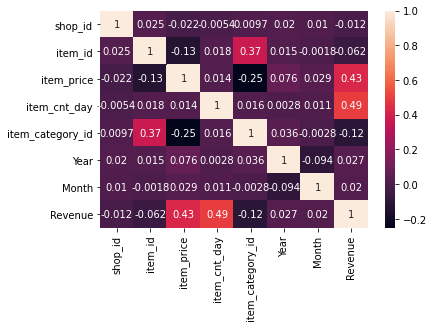

In [43]:
data = df1[['shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_category_id', 'Year', 'Month', 'Revenue']]
corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

From the correlation matrix, we can see that there are only few significant correlations between few variables. Item_category_id and item_id have positive correlation. Also, both Item_price and Item_cnt_day have positive correlation with Revenue. On the other hand, there is negative correlation between item_price and item_id. Item_category_id and Item_price also have negative correlation.

## 3.2 What is the overall sales trend?

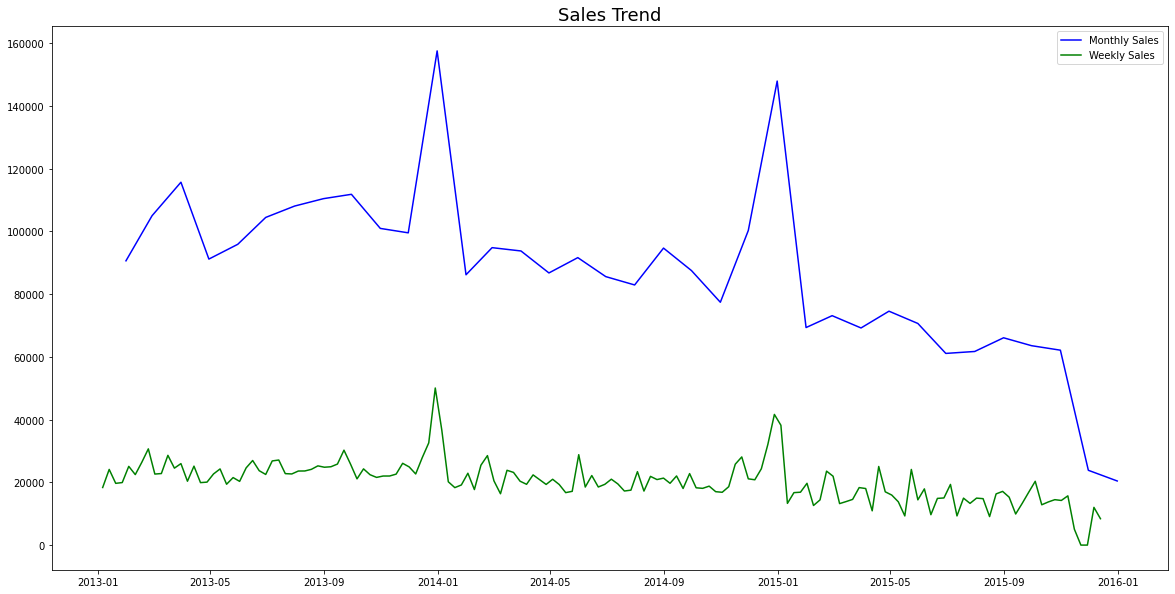

In [44]:
df_monthly = df1[['date', 'item_cnt_day']].set_index('date').resample('M').sum()
df_weekly = df1[['date', 'item_cnt_day']].set_index('date').resample('W').sum()

f = plt.figure(figsize=(20, 10))
plt.plot(df_monthly.index, df_monthly, color = 'blue', label = 'Monthly Sales')
plt.plot(df_weekly.index, df_weekly, color = 'green', label = 'Weekly Sales')
plt.title("Sales Trend", fontsize=18)
plt.legend()

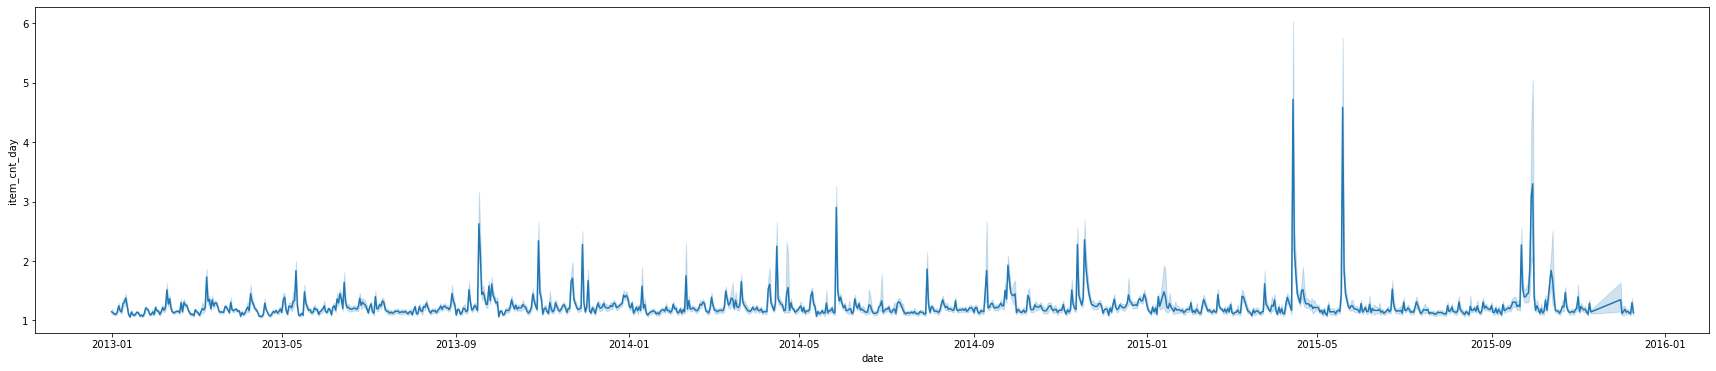

In [45]:
plt.figure(figsize=(30,6));
sns.lineplot(x='date',y='item_cnt_day',data=df1)

From the above graphs, we can see that the sales seemed to be more similiar between year 2013 and year 2014. Moreover, there seems to have one-year or six-months cycle of sales trend. Therefore, we try to consider using the most recent six months sales data for prediction and include lag 6 and lag 12 in the further model building.

Text(0, 0.5, 'Total Counts')

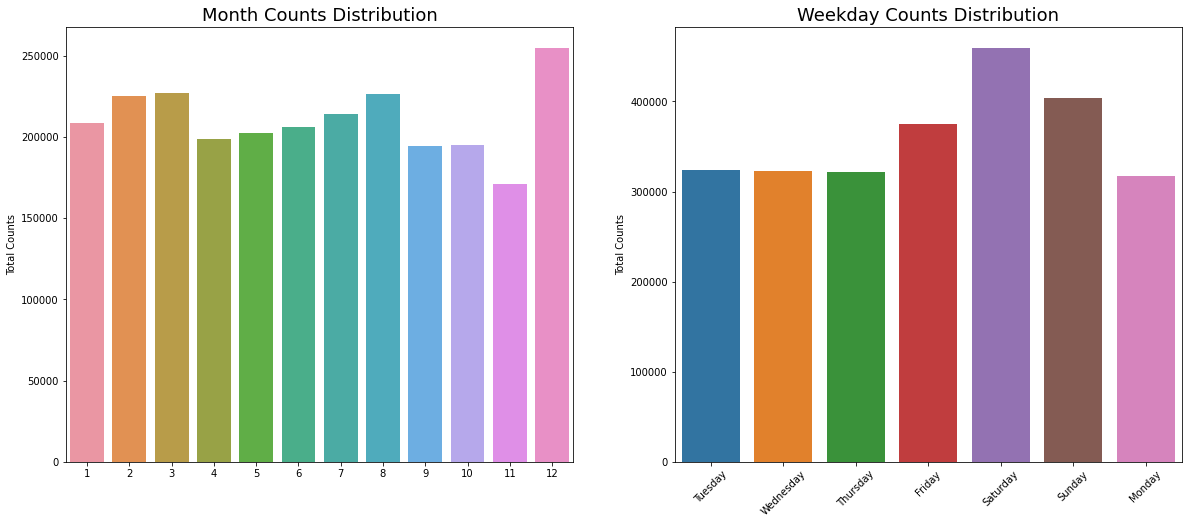

In [46]:
f, axes = plt.subplots(1, 2, figsize=(20,8))

ax1 = sns.countplot(df1['Month'], ax = axes[0])
ax1.set_xticklabels(ax1.get_xticklabels())
ax1.set_title("Month Counts Distribution", fontsize=18)
ax1.set_xlabel("")
ax1.set_ylabel("Total Counts", fontsize=10)

ax2 = sns.countplot(df1['Weekday'], ax = axes[1])
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45)
ax2.set_title("Weekday Counts Distribution", fontsize=18)
ax2.set_xlabel("")
ax2.set_ylabel("Total Counts", fontsize=10)

From the above graph, we can see that from the month perspective, December seemed to have the most sales. From the weekday perspective, Saturday seemed to have the most sales.

## 3.3 What is the top 10 popular category names?

Text(0, 0.5, 'Total Counts')

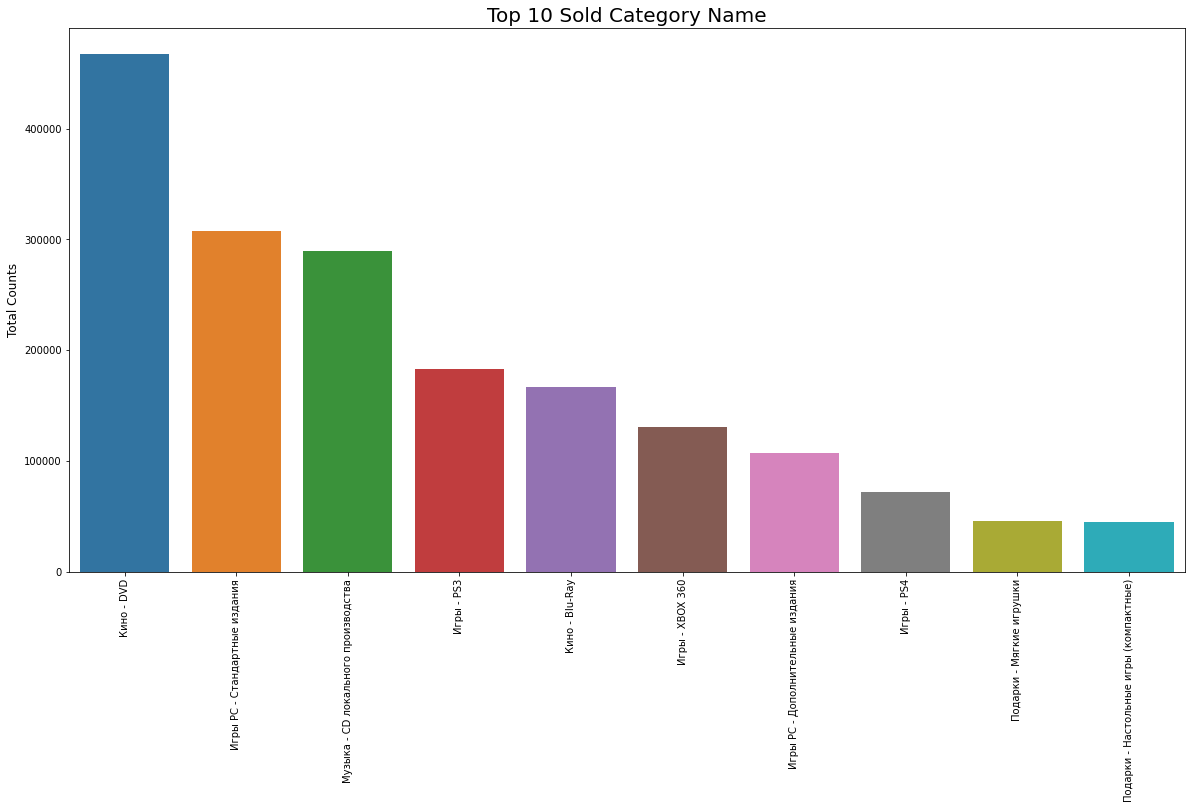

In [47]:
fig = plt.figure(figsize=(20,10))
top_category = sns.countplot(df1['item_category_name'], order=pd.value_counts(df1['item_category_name']).iloc[:10].index)
top_category.set_xticklabels(top_category.get_xticklabels(),rotation=90)
top_category.set_title("Top 10 Sold Category Name", fontsize=20)
top_category.set_xlabel("")
top_category.set_ylabel("Total Counts", fontsize=12)

The top 10 sold item category are mostly DVD, video gaming devices, wuch as PS3 and XBOX 360, and PC.

## 3.4 What is the number of item sold by each store?

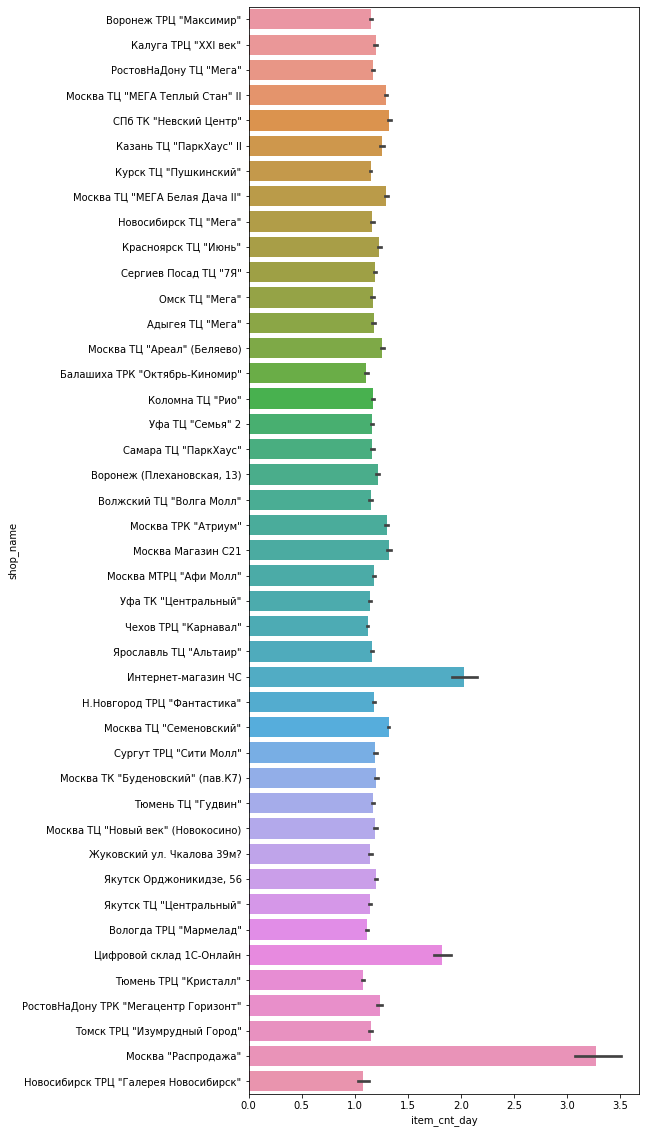

In [48]:
fig = plt.figure(figsize=(7,20))
sns.barplot(x='item_cnt_day',y='shop_name',data=df1)

From the above graph, we can see that most of the shops seemed to have similiar number of products sold. Only three shops have significant difference from other shops.

## 3.5 What's the sales trend of the DVD?

Text(0, 0.5, 'Average Sales Per Date')

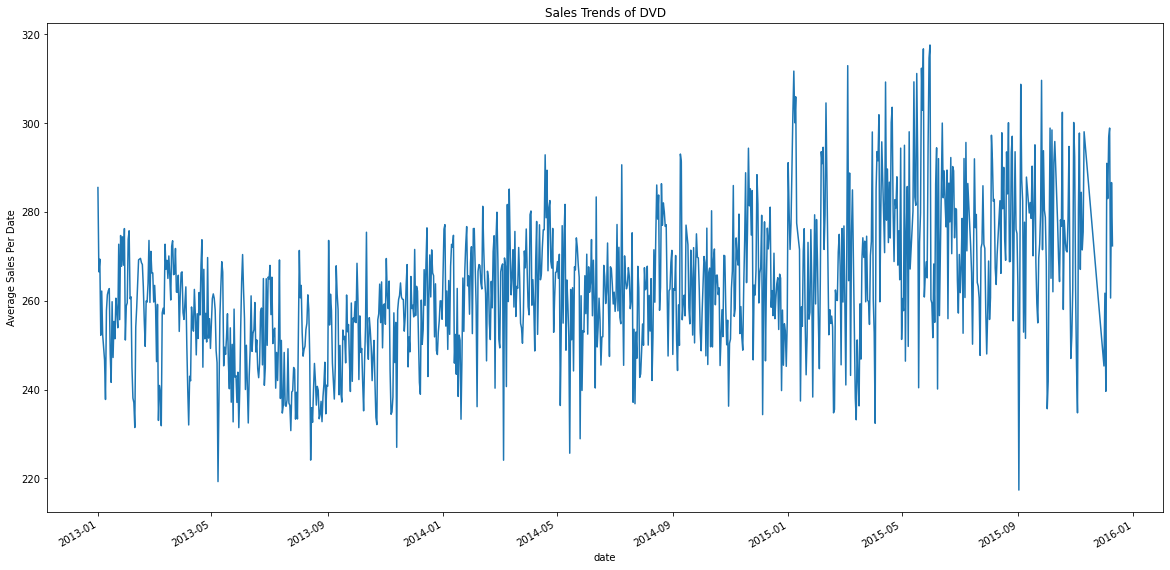

In [49]:
df1[df1["item_category_name"]=='Кино - DVD'].groupby("date").mean()["item_price"].plot(figsize=(20,10))
plt.title("Sales Trends of DVD")
plt.ylabel("Average Sales Per Date")

Since from the previous Top 10 Sold Category graph, DVD has the highest number of product sold among categories, we decide to take a look at the trend of the DVD. From the above graph, the average sales of DVD per day have increased over years.

## 3.6 What are the top 10 shops which occured the most times?

Text(0, 0.5, 'Count')

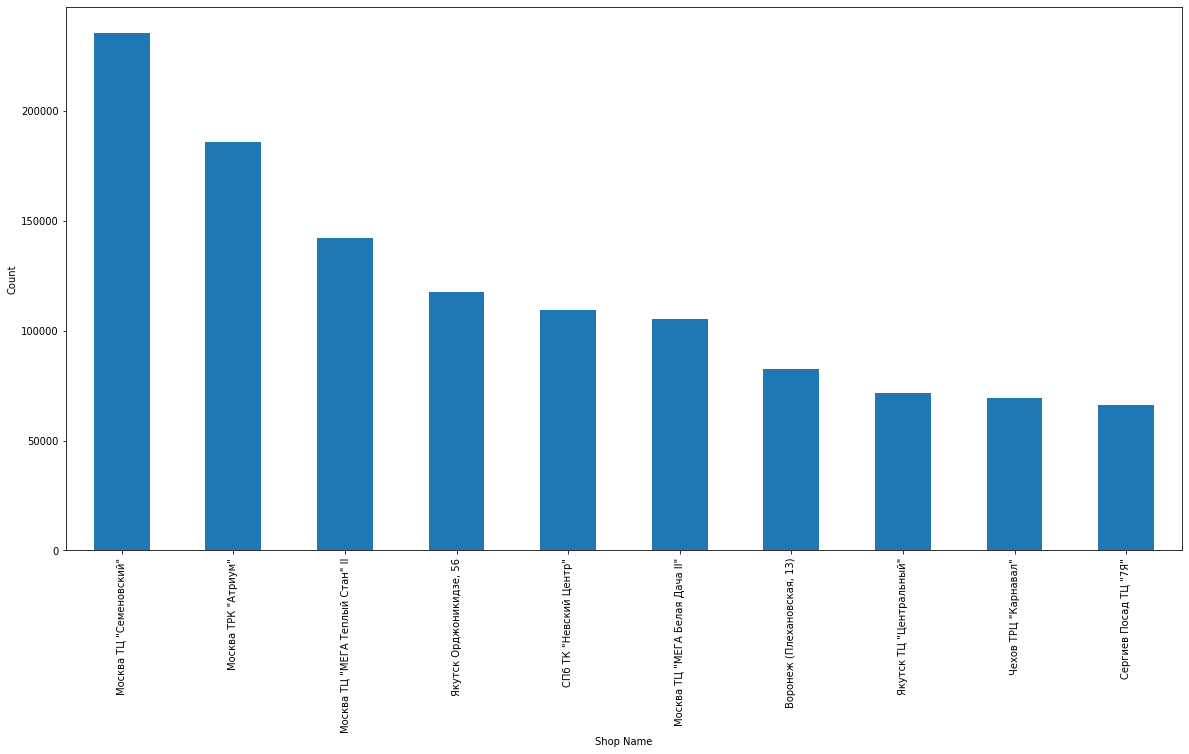

In [50]:
df1["shop_name"].value_counts()[0:10].plot(kind="bar", figsize=(20, 10))
plt.xlabel("Shop Name")
plt.ylabel("Count")

To learn more about the sales condition among different shops, we plot the top 10 shops that occurred the most times. Therefore, in the further model building, we deal with the categorical shop_id by using one-hot-encoding.

**After doing the EDA, we need to create a dataframe for modeling**

# 4. Initial Modeling

## 4.1 Create a new dataframe called whole

In [51]:
whole=[]

for i in range(0,34):
    shops_month=train.loc[train['date_block_num']==i,'shop_id'].unique()
    items_month=train.loc[train['date_block_num']==i,'item_id'].unique()
    whole.append(np.array(list(product([i],shops_month,items_month))))
    
whole=np.vstack(whole)
whole=pd.DataFrame(whole,columns=['date_block_num','shop_id','item_id'])

In [52]:
test['date_block_num']=34
test2=test[['date_block_num','shop_id','item_id']]
whole=pd.concat([whole,test2],axis=0)

In [53]:
whole.head(3)

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554


Calculate each item's monthly sale in each shop

In [54]:
sale = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':['sum']})
sale.columns = ['item_cnt_month']
sale.reset_index(inplace=True)
sale['item_cnt_month'] = (sale['item_cnt_month'].clip(0,20).astype(np.float))

In [55]:
whole = whole.merge(sale,how='left',on = ['date_block_num','shop_id','item_id'])
whole = whole.merge(shops,how='left',on='shop_id')
whole = whole.merge(items,how='left',on='item_id')
whole = whole.merge(item_cats2,how='left',on='item_category_id')

Set month and year

In [56]:
def year_value(sd):
    if 0<=sd<=12:
        return 0
    elif 13<=sd<=24:
        return 1
    else:
        return 2

In [57]:
whole['month'] = whole['date_block_num'].apply(lambda x: x%12)

In [58]:
whole['year'] = whole['date_block_num'].apply(lambda x: year_value(x))

In [59]:
whole = whole.drop(['shop_name','item_name'],axis=1)

## 4.2 Adding more features

In [60]:
whole2 = whole.copy()

### 4.2.1 Every shop's average cnt

In [61]:
cnt_mean = whole.query("date_block_num<34").groupby("shop_id").agg({"item_cnt_month":["mean"]})

In [62]:
cnt_mean.columns = ['shop_id_mean']
whole2['shop_id_mean'] = whole2['shop_id'].map(cnt_mean['shop_id_mean'])

### 4.2.2 Every item's average count

In [63]:
item_mean = whole.query("date_block_num<34").groupby("item_id").agg({"item_cnt_month":["mean"]})

In [64]:
item_mean.columns = ['item_cnt_month']

In [65]:
whole2['item_cnt_mean'] = whole2['item_id'].map(item_mean['item_cnt_month'])

### 4.2.3 Every category's average count

In [66]:
c = whole.query("date_block_num<34").groupby("item_category_id").agg({"item_cnt_month":["mean"]})

In [67]:
c.columns = ['category_mean']

In [68]:
whole2['category_mean'] = whole['item_category_id'].map(c['category_mean'])

### 4.2.4 Every item's mean price

In [69]:
item_pr =  train.query("date_block_num<34").groupby("item_id").agg({"item_price":["mean"]})

In [70]:
item_pr.columns = ['item_mean_price']

In [71]:
whole2['item_mean_price'] = whole2['item_id'].map(item_pr['item_mean_price'])

Define a function to save memory usage.

In [72]:
def downcast_dtypes(df):
    cols_float64 = [c for c in df if df[c].dtype == 'float64']
    cols_int64_32 = [c for c in df if df[c].dtype in ['int64', 'int32']]
    df[cols_float64] = df[cols_float64].astype(np.float32)
    df[cols_int64_32] = df[cols_int64_32].astype(np.int16)
    return df

In [73]:
whole2 = downcast_dtypes(whole2)

Then we use these features to fit LGBM model.

We use date_block_number smaller than 33 as out training set, date_block_number equals to 33 as our validation set.

In [74]:
whole2 = whole2.drop('city',axis=1)

In [75]:
whole2 = whole2.fillna(0)

In [76]:
import lightgbm as lgb

In [77]:
X_train=whole2.drop("item_cnt_month",axis=1).query("date_block_num<33")
y_train=whole2.query("date_block_num<33")["item_cnt_month"]
X_val=whole2.drop("item_cnt_month",axis=1).query("date_block_num==33")
y_val=whole2.query("date_block_num==33")["item_cnt_month"]

In [78]:
lgb_train = lgb.Dataset(X_train,y_train)
lgb_eval = lgb.Dataset(X_val,y_val,reference=lgb_train)

In [79]:
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'rmse'},
        'learning_rate': 0.3,
        'num_leaves': 30,
        'min_data_in_leaf': 1,
        'num_iteration': 250,
        'verbose': 20
}

In [80]:
gbm = lgb.train(params,
            lgb_train,
            num_boost_round=1000,
            valid_sets=lgb_eval,
            early_stopping_rounds=10,
            categorical_feature=['item_id','item_category_id','type_code','product_code'])

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_category_id', 'item_id', 'product_code', 'type_code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's rmse: 1.05871
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 1.03412
[3]	valid_0's rmse: 1.02136
[4]	valid_0's rmse: 1.00744
[5]	valid_0's rmse: 0.985679
[6]	valid_0's rmse: 0.985731
[7]	valid_0's rmse: 0.982444
[8]	valid_0's rmse: 0.985082
[9]	valid_0's rmse: 0.979474
[10]	valid_0's rmse: 0.978802
[11]	valid_0's rmse: 0.975447
[12]	valid_0's rmse: 0.971713
[13]	valid_0's rmse: 0.971221
[14]	valid_0's rmse: 0.972099
[15]	valid_0's rmse: 0.971418
[16]	valid_0's rmse: 0.969168
[17]	valid_0's rmse: 0.968675
[18]	valid_0's rmse: 0.964305
[19]	valid_0's rmse: 0.964133
[20]	valid_0's rmse: 0.963913
[21]	valid_0's rmse: 0.963798
[22]	valid_0's rmse: 0.962646
[23]	valid_0's rmse: 0.960632
[24]	valid_0's rmse: 0.960491
[25]	valid_0's rmse: 0.960475
[26]	valid_0's rmse: 0.960483
[27]	valid_0's rmse: 0.954723
[28]	valid_0's rmse: 0.946405
[29]	valid_0's rmse: 0.943163
[30]	valid_0's rmse: 0.943104
[31]	valid_0's rmse: 0.94286
[32]	valid_0's rmse: 0

As the validation rmse is 0.89, which is not as good as expected. Then we assume, maybe include more feature like each day's sales of particular item or each shop's average sale.

# 5. Include other features

## 5.1 Adding date_item_mean features

In [81]:
date_item_mean = whole2.query("date_block_num<34").groupby(["date_block_num","item_id"]).agg({"item_cnt_month":["mean"]})

In [82]:
date_item_mean.columns = ['date_item_cnt_mean']
whole2 = whole2.merge(date_item_mean,on=['date_block_num','item_id'],how='left')

In [83]:
date_item_mean = date_item_mean.reset_index()

## 5.2 Adding date_shop_cnt_mean features

In [84]:
date_shop_mean = whole2.query("date_block_num<34").groupby(["date_block_num","shop_id"]).agg({"item_cnt_month":["mean"]})

In [85]:
date_shop_mean.columns = ['date_shop_cnt_mean']
date_shop_mean = date_shop_mean.reset_index()

In [86]:
whole2 = pd.merge(whole2,date_shop_mean,on=['date_block_num','shop_id'],how='left')

## 5.3 Adding date_shop_revenue_sum features

In [87]:
# train['revenue'] = train['item_cnt_day']*train['item_price']

In [88]:
# date_shop_rev = train.query('date_block_num<34').groupby(['date_block_num','shop_id']).agg({'revenue':['sum']})

In [89]:
# date_shop_rev.columns = ['date_shop_rev']

In [90]:
# date_shop_rev = date_shop_rev.reset_index()

In [91]:
# whole2= pd.merge(whole2,date_shop_rev,on=['date_block_num','shop_id'],how='left')

## 5.4 Adding date_cat_avg_item_cnt

In [92]:
date_cat = whole2.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})

In [93]:
date_cat.columns = [ 'date_cat_avg_item_cnt' ]

In [94]:
date_cat.reset_index(inplace=True)

In [95]:
date_cat.head(3)

,date_block_num,item_category_id,date_cat_avg_item_cnt
0,0,0,0.029412
1,0,1,0.029412
2,0,2,0.962803


In [96]:
whole2= pd.merge(whole2,date_cat,on=['date_block_num','item_category_id'],how='left')

In [97]:
whole2.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,product_code,month,year,shop_id_mean,item_cnt_mean,category_mean,item_mean_price,date_item_cnt_mean,date_shop_cnt_mean,date_cat_avg_item_cnt
0,0,59,22154,1.0,31,37,11,1,0,0,1.84367,1.139535,1.505574,670.428589,0.470588,0.265122,0.217326
1,0,59,2552,0.0,31,58,13,29,0,0,1.84367,0.714286,1.117337,936.500000,0.000000,0.265122,0.048651
2,0,59,2554,0.0,31,58,13,29,0,0,1.84367,1.000000,1.117337,1709.050049,0.029412,0.265122,0.048651


Still, we use train_validation set as before to check if our selection of features is appropriate.

In [98]:
X_train=whole2.drop("item_cnt_month",axis=1).query("date_block_num<33")
y_train=whole2.query("date_block_num<33")["item_cnt_month"]
X_val=whole2.drop("item_cnt_month",axis=1).query("date_block_num==33")
y_val=whole2.query("date_block_num==33")["item_cnt_month"]

In [99]:
lgb_train = lgb.Dataset(X_train,y_train)
lgb_eval = lgb.Dataset(X_val,y_val,reference=lgb_train)

In [100]:
gbm = lgb.train(params,
            lgb_train,
            num_boost_round=1000,
            valid_sets=lgb_eval,
            early_stopping_rounds=10,
            categorical_feature=['item_id','item_category_id','type_code','product_code'])

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['item_category_id', 'item_id', 'product_code', 'type_code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's rmse: 0.983776
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 0.89961
[3]	valid_0's rmse: 0.846882
[4]	valid_0's rmse: 0.810468
[5]	valid_0's rmse: 0.792861
[6]	valid_0's rmse: 0.774854
[7]	valid_0's rmse: 0.773101
[8]	valid_0's rmse: 0.767285
[9]	valid_0's rmse: 0.763846
[10]	valid_0's rmse: 0.753949
[11]	valid_0's rmse: 0.748924
[12]	valid_0's rmse: 0.734088
[13]	valid_0's rmse: 0.731992
[14]	valid_0's rmse: 0.73104
[15]	valid_0's rmse: 0.729233
[16]	valid_0's rmse: 0.728322
[17]	valid_0's rmse: 0.727997
[18]	valid_0's rmse: 0.726348
[19]	valid_0's rmse: 0.711967
[20]	valid_0's rmse: 0.706926
[21]	valid_0's rmse: 0.694082
[22]	valid_0's rmse: 0.694147
[23]	valid_0's rmse: 0.694055
[24]	valid_0's rmse: 0.692452
[25]	valid_0's rmse: 0.691356
[26]	valid_0's rmse: 0.690568
[27]	valid_0's rmse: 0.690457
[28]	valid_0's rmse: 0.690282
[29]	valid_0's rmse: 0.681185
[30]	valid_0's rmse: 0.681105
[31]	valid_0's rmse: 0.68074
[32]	valid_0's rmse:

As we see the rmse decrease from 0.89 to 0.66. Even though the accuracy improves slightly, the result is still as out expected.

<Figure size 5760x1152 with 0 Axes>

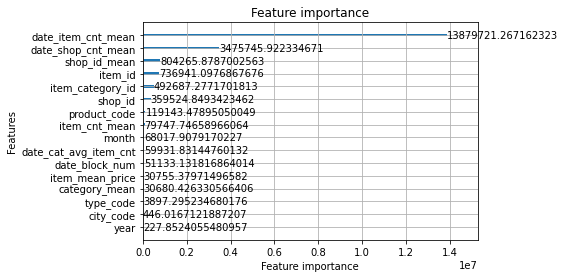

In [101]:
plt.figure(figsize=(80,16))
lgb.plot_importance(gbm, importance_type='gain')

From the importance plot we can see that the 'date_item_cnt_mean' is the most important feature in improving the accuracy. But some additional features like 'type_code' and 'city_code' rank lower than other features.

Then we find that, since this data is related to time series, what if we can use time series method to find some pattern and choose some features according to the behavior of our data.

# 6. Time Series 

## 6.1 Create a dataframe for time series model.

In [102]:
whole21 = whole2[['date_block_num','shop_id','item_id','item_category_id','shop_id_mean','item_cnt_mean','category_mean']]

In [103]:
train11 = train[['date','date_block_num','shop_id','item_id','item_cnt_day']]

In [104]:
tsdf = pd.merge(train11,whole21,on=['date_block_num','shop_id','item_id'])

In [105]:
tsdf['date'] = pd.to_datetime(tsdf['date'])

In [106]:
tsdf['Year'] = tsdf.date.dt.year
tsdf['Month'] = tsdf.date.dt.month
tsdf['Day'] = tsdf.date.dt.day
tsdf['Weekday'] = tsdf['date'].dt.day_name()

In [107]:
tsdf['time3'] = tsdf['date'].apply(lambda x:str(x)[:7]).tolist()

In [108]:
data1 = tsdf[['time3','item_cnt_mean']]

In [109]:
data1

,time3,item_cnt_mean
0,2013-02,1.139535
1,2013-03,0.714286
2,2013-05,0.714286
3,2013-06,1.000000
4,2013-01,1.075000
...,...,...
2524334,2015-10,1.416667
2524335,2015-11,1.294118
2524336,2015-10,1.164773
2524337,2015-10,1.452663


In [110]:
a = pd.DataFrame(data1.groupby(data1['time3']).sum())

In [111]:
a.index = pd.DatetimeIndex(a.index)

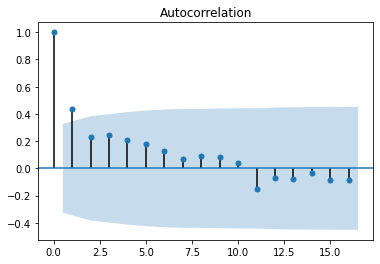

In [112]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
get_ipython().run_line_magic('matplotlib', 'inline')
plot_acf(a)
plt.show()
from statsmodels.tsa.stattools import adfuller

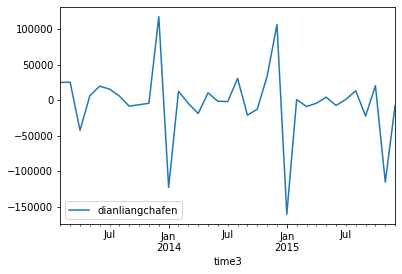

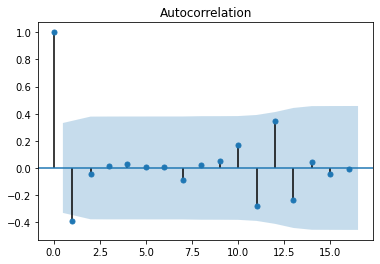

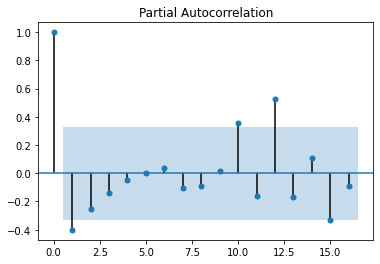

result：  (-5.832730645187151, 3.9404999951159817e-07, 1, 33, {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}, 587.9740951354141)
result： (array([5.79867578]), array([0.01603825]))


In [113]:
D_data = a.diff().dropna()
D_data.columns = [u'dianliangchafen']
D_data.plot() 
plt.show()
plot_acf(D_data)    
plt.show()
plot_pacf(D_data)  
plt.show()
print(u'result： ', adfuller(D_data[u'dianliangchafen']))  
from statsmodels.stats.diagnostic import acorr_ljungbox
print(u'result：',acorr_ljungbox(D_data, lags= 1)) 

As we can see from the autocorrelation and partial autocorrelation, the item_sales shows a yearly trend. Maybe it is a whole year, or a half-year trend. In this way, we may inlcude some lag features, that means every item's sale is almost the same as months ago. It is like a sliding window method. 

# 7. Additional features

## 7.1 date_item_cnt_mean_lagx

### 7.1.1 date_item_cnt_mean_lag1

In [114]:
date_item_mean['date_block_num']=date_item_mean['date_block_num']+1

In [115]:
date_item_mean.columns = ['date_block_num', 'item_id', 'date_item_cnt_mean_lag1']

In [116]:
whole2 = pd.merge(whole2,date_item_mean,how='left',on=['date_block_num','item_id'])

### 7.1.2 date_item_cnt_mean_lag2

In [117]:
date_item_mean['date_block_num']=date_item_mean['date_block_num']+1

In [118]:
date_item_mean.columns = ['date_block_num', 'item_id', 'date_item_cnt_mean_lag2']

In [119]:
whole2 = whole2.merge(date_item_mean,how='left',on=['date_block_num','item_id'])

### 7.1.3 date_item_cnt_mean_lag3

In [120]:
date_item_mean['date_block_num']=date_item_mean['date_block_num']+1

In [121]:
date_item_mean.columns = ['date_block_num', 'item_id', 'date_item_cnt_mean_lag3']

In [122]:
whole2 = whole2.merge(date_item_mean,how='left',on=['date_block_num','item_id'])

### 7.1.4 date_item_cnt_mean_lag6

In [123]:
date_item_mean['date_block_num']=date_item_mean['date_block_num']+5

In [124]:
date_item_mean.columns = ['date_block_num', 'item_id', 'date_item_cnt_mean_lag6']

In [125]:
whole2 = pd.merge(whole2,date_item_mean,how='left',on=['date_block_num','item_id'])

### 7.1.5 date_item_cnt_mean_lag12

In [126]:
date_item_mean['date_block_num']=date_item_mean['date_block_num']+6

In [127]:
date_item_mean.columns = ['date_block_num', 'item_id', 'date_item_cnt_mean_lag12']

In [128]:
whole2 = pd.merge(whole2,date_item_mean,how='left',on=['date_block_num','item_id'])

## 7.2 date_shop_cnt_mean_lagx
(These features are useless)

### 7.2.1 date_shop_cnt_mean_lag1

In [129]:
# date_shop_mean['date_block_num'] = date_shop_mean['date_block_num'] + 1

In [130]:
# date_shop_mean.columns = ['date_block_num', 'item_id', 'date_shop_cnt_mean_lag1']

In [131]:
# whole2 = whole2.merge(date_shop_mean,how='left',on=['date_block_num','item_id'])

### 7.2.2 date_shop_cnt_mean_lag2

In [132]:
# date_shop_mean['date_block_num'] = date_shop_mean['date_block_num'] + 1

In [133]:
# date_shop_mean.columns = ['date_block_num', 'item_id', 'date_shop_cnt_mean_lag2']

In [134]:
# whole2 = pd.merge(whole2,date_shop_mean,how='left',on=['date_block_num','item_id'])

### 7.2.3 date_shop_cnt_mean_lag3

In [135]:
# date_shop_mean['date_block_num'] = date_shop_mean['date_block_num'] + 1

In [136]:
# date_shop_mean.columns = ['date_block_num', 'item_id', 'date_shop_cnt_mean_lag3']

In [137]:
# whole2 = pd.merge(whole2,date_shop_mean,how='left',on=['date_block_num','item_id'])

### 7.2.4 date_shop_cnt_mean_lag6

In [138]:
# date_shop_mean['date_block_num'] = date_shop_mean['date_block_num'] + 5

In [139]:
# date_shop_mean.columns = ['date_block_num', 'item_id', 'date_shop_cnt_mean_lag6']

In [140]:
# whole2 = whole2.merge(date_shop_mean,how='left',on=['date_block_num','item_id'])

### 7.2.5 date_shop_cnt_mean_lag12

In [141]:
# date_shop_mean['date_block_num'] = date_shop_mean['date_block_num'] + 6

In [142]:
# date_shop_mean.columns = ['date_block_num', 'item_id', 'date_shop_cnt_mean_lag12']

In [143]:
# whole2 = pd.merge(whole2,date_shop_mean,how='left',on=['date_block_num','item_id'])

# 8. OneHotEncoding
We also notice that, since shop_id is a categorical type, then we may need to convert this feature from numerical to categorical. Because some model do not accept 'category' type, so we use OneHotEncoding method to do this.

There are 60 shops in this data, and more than 20,000 items. Due to time complexity, we only convert 'shop_id' feature.

In [144]:
whole3 = whole2.copy()

In [145]:
def downcast_dtypes(df):
    cols_float64 = [c for c in df if df[c].dtype == 'float64']
    cols_int64_32 = [c for c in df if df[c].dtype in ['int64', 'int32']]
    df[cols_float64] = df[cols_float64].astype(np.float16)
    df[cols_int64_32] = df[cols_int64_32].astype(np.int16)
    return df

In [146]:
whole3 = downcast_dtypes(whole3)

In [147]:
whole4 = whole3.transpose()

In [148]:
onehot = pd.DataFrame(pd.get_dummies(whole3.shop_id, prefix='shop_id')).transpose()

In [149]:
whole5 = whole4.append(onehot)

In [150]:
whole5 = whole5.transpose()

In [151]:
whole5.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,product_code,month,year,shop_id_mean,item_cnt_mean,category_mean,item_mean_price,date_item_cnt_mean,date_shop_cnt_mean,date_cat_avg_item_cnt,date_item_cnt_mean_lag1,date_item_cnt_mean_lag2,date_item_cnt_mean_lag3,date_item_cnt_mean_lag6,date_item_cnt_mean_lag12,shop_id_2,shop_id_3,shop_id_4,shop_id_5,shop_id_6,shop_id_7,shop_id_10,shop_id_12,shop_id_14,shop_id_15,shop_id_16,shop_id_18,shop_id_19,shop_id_20,shop_id_21,shop_id_22,shop_id_24,shop_id_25,shop_id_26,shop_id_27,shop_id_28,shop_id_29,shop_id_31,shop_id_34,shop_id_35,shop_id_36,shop_id_37,shop_id_38,shop_id_39,shop_id_41,shop_id_42,shop_id_44,shop_id_45,shop_id_46,shop_id_47,shop_id_48,shop_id_49,shop_id_50,shop_id_52,shop_id_53,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
0,0.0,59.0,22154.0,1.0,31.0,37.0,11.0,1.0,0.0,0.0,1.84367,1.139535,1.505574,670.428589,0.470588,0.265122,0.217326,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,59.0,2552.0,0.0,31.0,58.0,13.0,29.0,0.0,0.0,1.84367,0.714286,1.117337,936.500000,0.000000,0.265122,0.048651,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,59.0,2554.0,0.0,31.0,58.0,13.0,29.0,0.0,0.0,1.84367,1.000000,1.117337,1709.050049,0.029412,0.265122,0.048651,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,59.0,2555.0,0.0,31.0,56.0,13.0,5.0,0.0,0.0,1.84367,1.075000,1.339500,1119.923218,0.058824,0.265122,0.063517,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,59.0,2564.0,0.0,31.0,59.0,13.0,42.0,0.0,0.0,1.84367,1.114286,1.165667,341.307678,0.117647,0.265122,0.096839,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [152]:
whole5 = whole5.drop('shop_id',axis=1)

In [153]:
whole5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8976147 entries, 0 to 8976146
Data columns (total 66 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   date_block_num            float32
 1   item_id                   float32
 2   item_cnt_month            float32
 3   city_code                 float32
 4   item_category_id          float32
 5   type_code                 float32
 6   product_code              float32
 7   month                     float32
 8   year                      float32
 9   shop_id_mean              float32
 10  item_cnt_mean             float32
 11  category_mean             float32
 12  item_mean_price           float32
 13  date_item_cnt_mean        float32
 14  date_shop_cnt_mean        float32
 15  date_cat_avg_item_cnt     float32
 16  date_item_cnt_mean_lag1   float32
 17  date_item_cnt_mean_lag2   float32
 18  date_item_cnt_mean_lag3   float32
 19  date_item_cnt_mean_lag6   float32
 20  date_item_cnt_mean_lag12

In [154]:
def downcast_dtypes(df):
    cols_float64 = [c for c in df if df[c].dtype == 'float32']
    cols_int64_32 = [c for c in df if df[c].dtype in ['int64', 'int32']]
    df[cols_float64] = df[cols_float64].astype(np.float16)
    df[cols_int64_32] = df[cols_int64_32].astype(np.int16)
    return df

In [155]:
whole6 = downcast_dtypes(whole5)

In [156]:
whole6 = whole6.fillna(0)

In [157]:
X_train=whole6.drop("item_cnt_month",axis=1).query("date_block_num<33 & date_block_num >=27")
y_train=whole6.query("date_block_num<33 & date_block_num >=27")["item_cnt_month"]
X_val=whole6.drop("item_cnt_month",axis=1).query("date_block_num==33")
y_val=whole6.query("date_block_num==33")["item_cnt_month"]

# 9. Modelling

## 9.1 Lasso Regression

In [158]:
alphas = 10**np.linspace(6,-2,50)*0.5

In [159]:
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error

lasso_cv = LassoCV(alphas = None, cv = 5, max_iter = 100000, normalize = True)
lasso_cv.fit(X_val, y_val)
lasso_model = Lasso(max_iter = 10000, normalize = True)
lasso_model.set_params(alpha = lasso_cv.alpha_)
print("Alpha:", lasso_cv.alpha_)

Alpha: 4.0473086434535944e-05


In [160]:
lasso_model.fit(X_train, y_train)
print("RMSE:{0:.5f}".format(np.sqrt(mean_squared_error(y_train, lasso_model.predict(X_train)))))

RMSE:0.80039


## 9.2 Ridge Regression

In [161]:
ridge_cv = RidgeCV(alphas = alphas, cv = 5, normalize = True)
ridge_cv.fit(X_val, y_val)
print("Alpha:", ridge_cv.alpha_)
ridge_model = Ridge(alpha = ridge_cv.alpha_, normalize = True)

Alpha: 0.04770477381749972


In [162]:
ridge_model.fit(X_train, y_train)
print("RMSE:{0:.5f}".format(np.sqrt(mean_squared_error(y_train, ridge_model.predict(X_train)))))

RMSE:0.79923


## 9.3 Elastic Net

In [163]:
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.metrics import mean_squared_error

In [164]:
# Use validation set to figure out what alpha value is good for our model
# Define multiple values and check the performance accuracy
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

# Define ElasticNet model by setting alpha and train it with x and y data
# For each alpha, we check the MSE, and RMSE metrics
for a in alphas:
    elastic_model = ElasticNet(alpha=a).fit(X_val,y_val)   
    pred_y = elastic_model.predict(X_val)
    mse = mean_squared_error(y_val, pred_y)   
    print("Alpha:{0:.4f}, MSE:{1:.5f}, RMSE:{2:.5f}".format(a, mse, np.sqrt(mse)))

Alpha:0.0001, MSE:0.71894, RMSE:0.84790
Alpha:0.0010, MSE:0.71896, RMSE:0.84792
Alpha:0.0100, MSE:0.72120, RMSE:0.84923
Alpha:0.1000, MSE:0.77455, RMSE:0.88008
Alpha:0.3000, MSE:0.86381, RMSE:0.92941
Alpha:0.5000, MSE:0.97535, RMSE:0.98760
Alpha:0.7000, MSE:1.08939, RMSE:1.04374
Alpha:1.0000, MSE:1.25346, RMSE:1.11958


In [165]:
# From the above result, we can see that when alpha = 0.0001, the MSE and RMSE is the lowest.
# Therefore, we use alpha = 0.0001 in our model.
elastic = ElasticNet(alpha=0.0001).fit(X_train, y_train)
y_pred = elastic.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print("MSE:{0:.5f}, RMSE:{1:.5f}".format(mse, np.sqrt(mse)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223.209260407486, tolerance: 155.72972570732347
  positive)


MSE:0.63649, RMSE:0.79780


In [166]:
# Use ElasticNetCV cross validation class to search again multiple alpha values and applies the best one to model
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
elastic_cv = ElasticNetCV(alphas=alphas, cv=5)
model = elastic_cv.fit(X_train, y_train)

In [167]:
print(model.alpha_)

0.001


In [168]:
# From the above result, the cross validation class select the same alpha as above, which is 0.0001.
y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print("MSE:{0:.5f}, RMSE:{1:.5f}".format(mse, np.sqrt(mse)))

MSE:0.63652, RMSE:0.79782


## 9.4 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor 
m = RandomForestRegressor(n_jobs=-1,oob_score=True)
%time m.fit(X_train, y_train)

In [ ]:
y_pred_rf = m.predict(X_val)

In [ ]:
#return RMSE
from sklearn import metrics
import numpy as np
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred_rf)))

In [ ]:
#return feature importance
names = list(X_train.columns)
rff = sorted(zip(map(lambda x: round(x, 4), m.feature_importances_), names), 
             reverse=True)

In [ ]:
rff = pd.DataFrame(rff)

In [ ]:
rff.plot(kind='bar',x=1,y=0)

## 9.5 XGBoost

The jupyter lab always crashed if we include too many features when building xgboost model. Therefore, we select some features based on our previous model's result as the final features to build the model.

In [170]:
whole7 =whole6.drop(['shop_id_mean','item_cnt_mean','category_mean','item_mean_price','date_shop_cnt_mean','date_cat_avg_item_cnt',
                     'date_item_cnt_mean_lag2','date_item_cnt_mean_lag3','month','year'],axis=1)

In [171]:
X_train=whole7.drop("item_cnt_month",axis=1).query("date_block_num<33 & date_block_num >=27")
y_train=whole7.query("date_block_num<33 & date_block_num >=27")["item_cnt_month"]
X_val=whole7.drop("item_cnt_month",axis=1).query("date_block_num==33")
y_val=whole7.query("date_block_num==33")["item_cnt_month"]

In [172]:
!pip uninstall xgboost
# !wget https://s3-us-west-2.amazonaws.com/xgboost-wheels/xgboost-0.81-py2.py3-none-manylinux1_x86_64.whl
!pip install xgboost-0.81-py2.py3-none-manylinux1_x86_64.whl

Uninstalling xgboost-0.81:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/xgboost-0.81.dist-info/*
    /usr/local/lib/python3.6/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.81
Processing ./xgboost-0.81-py2.py3-none-manylinux1_x86_64.whl


In [173]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [174]:
model = XGBRegressor(
    tree_method = 'gpu_hist',
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

In [175]:
model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:1.0752	validation_1-rmse:1.09539
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.0458	validation_1-rmse:1.06813
[2]	validation_0-rmse:0.999342	validation_1-rmse:1.02679
[3]	validation_0-rmse:0.97881	validation_1-rmse:1.00781
[4]	validation_0-rmse:0.940757	validation_1-rmse:0.973252
[5]	validation_0-rmse:0.908974	validation_1-rmse:0.943905
[6]	validation_0-rmse:0.882618	validation_1-rmse:0.920032
[7]	validation_0-rmse:0.859713	validation_1-rmse:0.899406
[8]	validation_0-rmse:0.83957	validation_1-rmse:0.881733
[9]	validation_0-rmse:0.82324	validation_1-rmse:0.867683
[10]	validation_0-rmse:0.816194	validation_1-rmse:0.861898
[11]	validation_0-rmse:0.802844	validation_1-rmse:0.849914
[12]	validation_0-rmse:0.791672	validation_1-rmse:0.840316
[13]	validation_0-rmse:0.782627	validation_1-rmse:0.831909
[14]	validation_0-rmse:0.779021	vali

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.8, eta=0.3, gamma=0, learning_rate=0.1,
             max_delta_step=0, max_depth=8, min_child_weight=300, missing=None,
             n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=True, subsample=0.8, tree_method='gpu_hist')

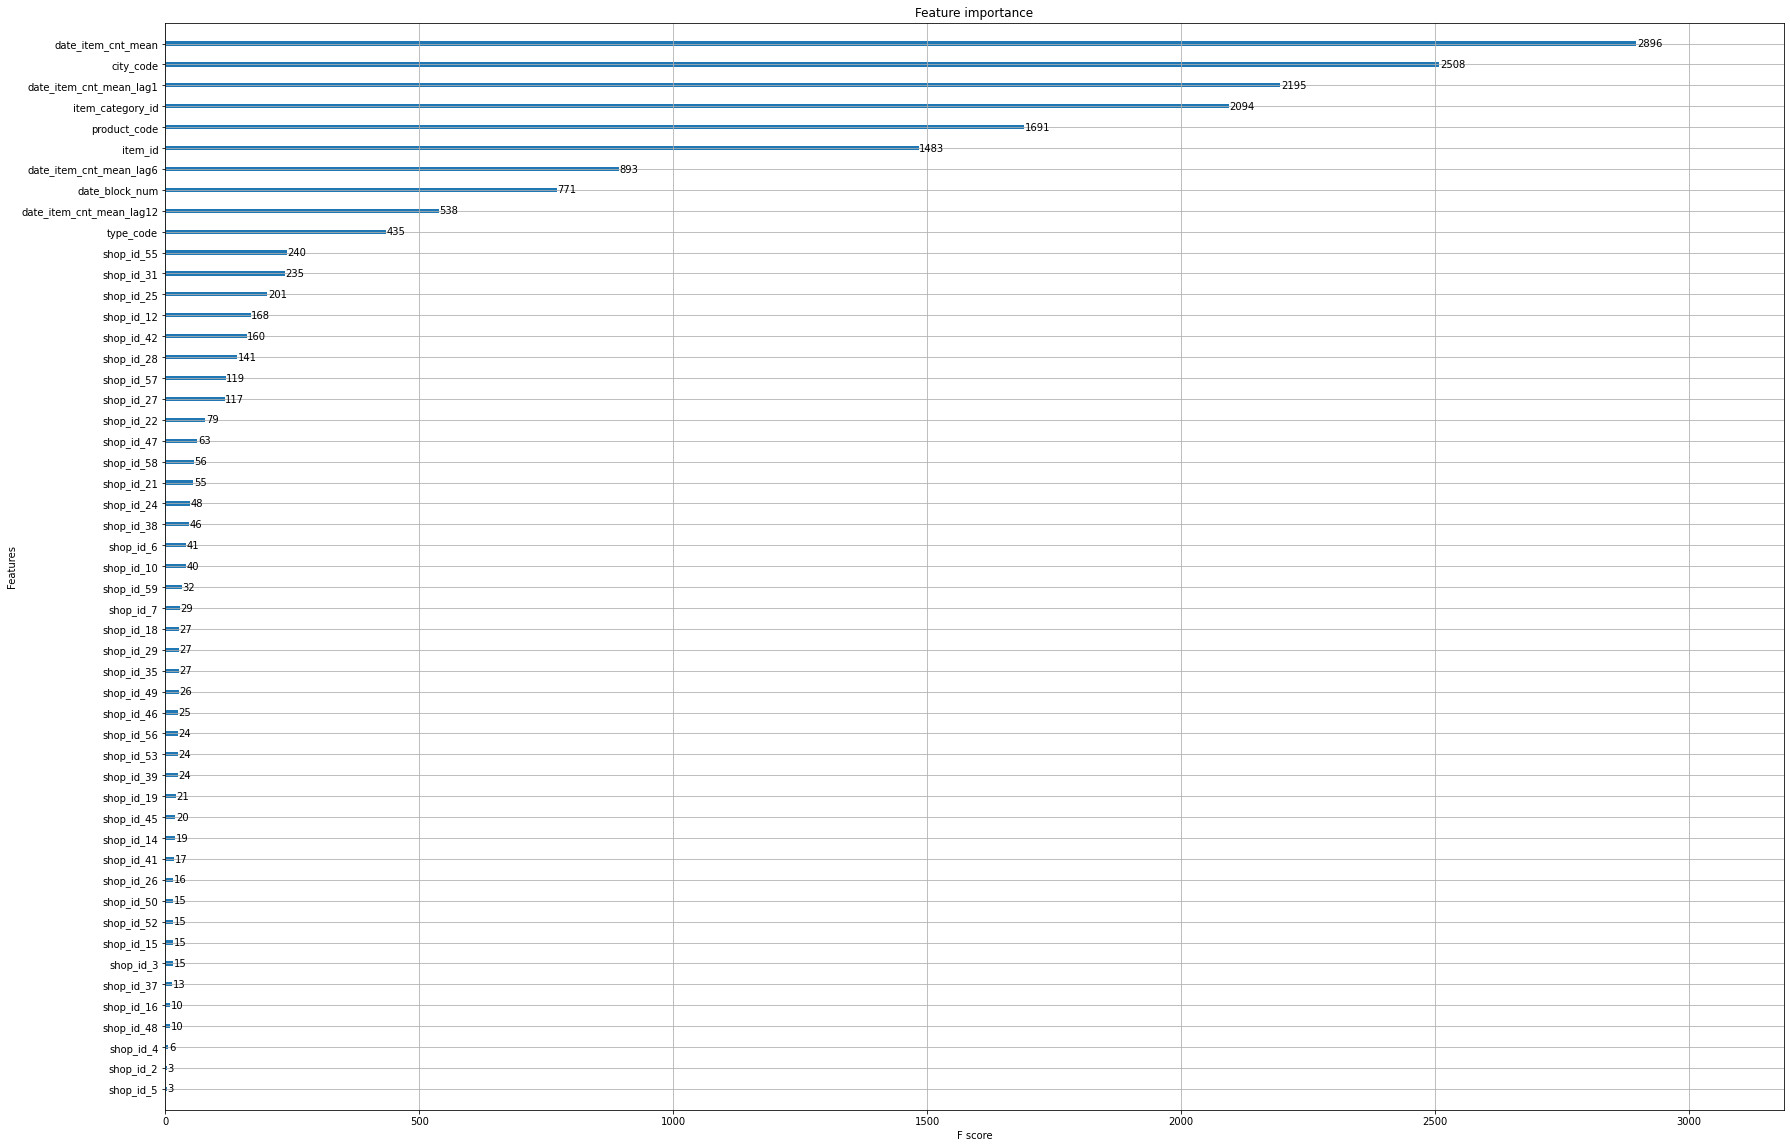

In [176]:
plt.rcParams["figure.figsize"] = (29, 20)
plot_importance(model)

In [177]:
X_test=whole7.drop("item_cnt_month",axis=1).query("date_block_num==34")

In [178]:
y_test_pred = model.predict(X_test)

In [179]:
test = pd.read_csv("sample_data/test.csv")

In [180]:
y_test_pred

array([ 2.3138344e-02, -3.2609105e-03, -1.0846376e-02, ...,
       -4.3693781e-03, -2.6339352e-02,  9.1075897e-05], dtype=float32)

In [181]:
sub = pd.DataFrame({"ID" : test.ID.values,
             "item_cnt_month" : y_test_pred})

In [182]:
sub.head(3)

,ID,item_cnt_month
0,0,0.023138
1,1,-0.003261
2,2,-0.010846


In [183]:
sub.to_csv("sub_xgbquarter23464.csv",index=False)

## 8.6 LGBM

In [184]:
import lightgbm as lgb

In [185]:
lgb_train = lgb.Dataset(X_train,y_train)
lgb_eval = lgb.Dataset(X_val,y_val,reference=lgb_train)

In [186]:
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'rmse'},
        'learning_rate': 0.3,
        'num_leaves': 30,
        'min_data_in_leaf': 1,
        'num_iteration': 250,
        'verbose': 20
}

In [ ]:
gbm = lgb.train(params,
            lgb_train,
            num_boost_round=1000,
            valid_sets=lgb_eval,
            early_stopping_rounds=10,
            categorical_feature=['item_id','item_category_id','type_code','product_code'])

In [ ]:
te2 = pd.read_csv("sample_data/test.csv")

In [ ]:
y_test = gbm.predict(X_test)

In [ ]:
fin = pd.DataFrame({"ID":te2.ID.values,
              "item_cnt_month":y_test})

In [ ]:
fin.to_csv("sub222.csv",index=False)

# Partial Dependence Plot

In [187]:
try:
  import pdpbox
except:
  !pip install pdpbox
  import pdpbox as pdp


In [189]:
from pdpbox import pdp, info_plots

In [190]:
X_val.head(3)

,date_block_num,item_id,city_code,item_category_id,type_code,product_code,date_item_cnt_mean,date_item_cnt_mean_lag1,date_item_cnt_mean_lag6,date_item_cnt_mean_lag12,shop_id_2,shop_id_3,shop_id_4,shop_id_5,shop_id_6,shop_id_7,shop_id_10,shop_id_12,shop_id_14,shop_id_15,shop_id_16,shop_id_18,shop_id_19,shop_id_20,shop_id_21,shop_id_22,shop_id_24,shop_id_25,shop_id_26,shop_id_27,shop_id_28,shop_id_29,shop_id_31,shop_id_34,shop_id_35,shop_id_36,shop_id_37,shop_id_38,shop_id_39,shop_id_41,shop_id_42,shop_id_44,shop_id_45,shop_id_46,shop_id_47,shop_id_48,shop_id_49,shop_id_50,shop_id_52,shop_id_53,shop_id_55,shop_id_56,shop_id_57,shop_id_58,shop_id_59
8542884,33.0,13312.0,20.0,47.0,12.0,39.0,0.146362,0.024994,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8542885,33.0,13880.0,20.0,55.0,13.0,4.0,1.829102,1.325195,2.250000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8542886,33.0,13880.0,20.0,55.0,13.0,4.0,1.170898,0.799805,1.224609,1.633789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


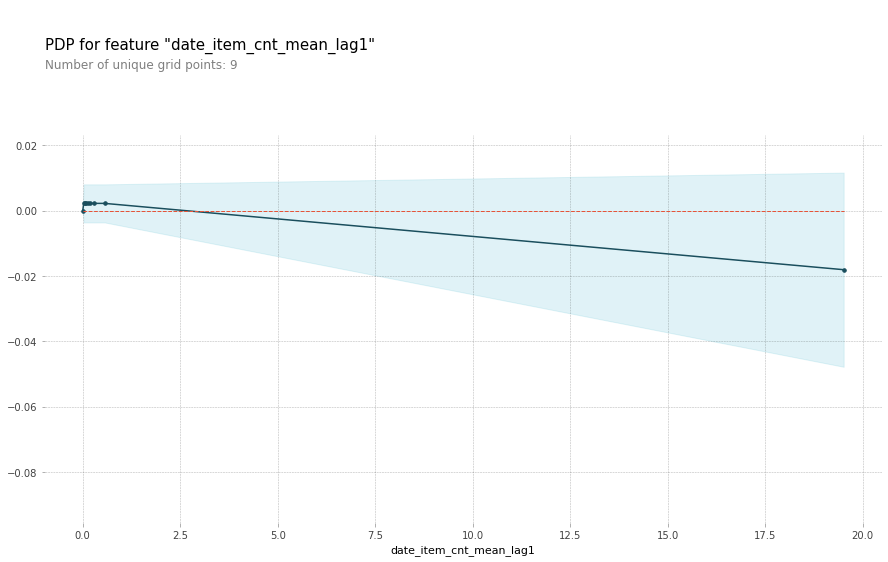

In [191]:
pdp_lag1 = pdp.pdp_isolate(model=model, dataset=X_train,
                            model_features=X_val.columns.tolist(), feature='date_item_cnt_mean_lag1')

pdp.pdp_plot(pdp_lag1, 'date_item_cnt_mean_lag1')
plt.show()

As the value of date_item_cnt_mean_lag1 increases, the prediction of month sales decreases. Also, similarly, and the value of date_item_cnt_mean_lag6 increases, the prediction of month sales decreases.

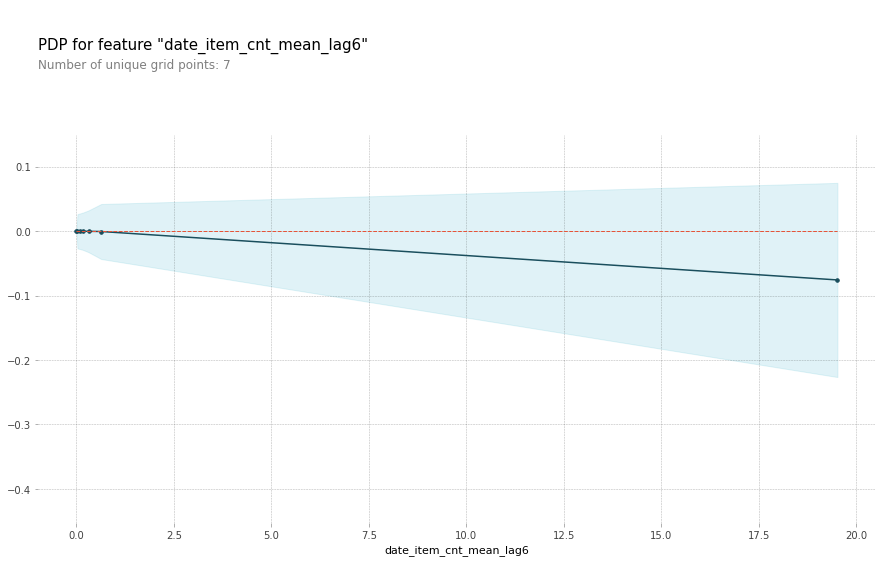

In [192]:
pdp_lag6 = pdp.pdp_isolate(model=model, dataset=X_train,
                            model_features=X_val.columns.tolist(), feature='date_item_cnt_mean_lag6')

pdp.pdp_plot(pdp_lag6, 'date_item_cnt_mean_lag6')
plt.show()

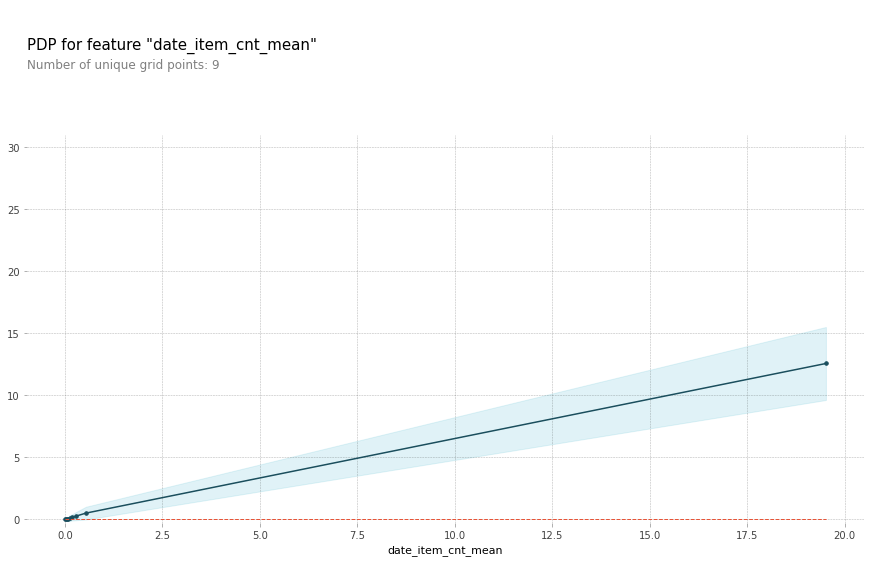

In [193]:
pdp_cnt = pdp.pdp_isolate(model=model, dataset=X_train,
                            model_features=X_val.columns.tolist(), feature='date_item_cnt_mean')

pdp.pdp_plot(pdp_cnt, 'date_item_cnt_mean')
plt.show()

As the value of date_item_cnt_mean increases, the prediction of month sales increases.

# SHAP Values

In [ ]:
# try:
#   import shap
# except:
#   !pip install shap
#   import shap

In [ ]:
# shap.initjs()

In [ ]:
# import shap

In [ ]:
# explainer = shap.TreeExplainer(model)

In [ ]:
# shap_values = explainer.shap_values(X_val)

In [ ]:
# shap.summary_plot(shap_values,features = X_val,feature_names=X_val.columns)